# Credit Card Fraud Analysis
***
#### Overview:
In this experiment, we will attempt to tackle the ubiquitous credit card fraud detection problem. This is a particularly interesting problem for the following reasons:
* Dataset is imbalanced. This requires changes to the traditional machine learning approach used for balanced datasets.
* Due to the nature of this problem, Recall will be the main metric used to evaluate model performance, Precision will be secondary
  * Recall is the proportion of positive samples properly being labeled as positive. In this case, 100% recall would result in 100% of fraudulent cases being reported as fraudulent. We would rather have false positives than false negatives when identifying CC fraud.
  * Precision is the secondary measure. It determines the proportion of positive-labeled samples being labeled properly. 100% precision means 0 false positives were reported.

**Additional notes: **
* The example dataset used in this notebook was found on Kaggle.com and has already undergone feature extraction for the sake of anonymization. Out of the box, it was already almost entirely clean, thus this experiment is mostly an exercise in modeling rather than data engineering.
* The workflow follows the initial iteration of the CRISP-DM development cycle.
  1. Business Understanding (given in Kaggle description)
  2. Data Understanding/Preparation
    1. Extract data
    2. Create a base table to use for modeling
    3. Visualize it
  3. Modeling
    1. Train various ML models
    2. Try various sampling methods to balance dataset
    3. Identify which model/sampling method performs the best
    4. Parameterize the chosen model
  4. Deployment
    1. Persist model
    2. Deploy model to service in desired manner

**Source:** [https://www.kaggle.com/mlg-ulb/creditcardfraud/home](https://www.kaggle.com/mlg-ulb/creditcardfraud/home)
***

In [62]:
##########################################
# Setup project path to use 
# data_exploration.py and ml_modeling.py
##########################################

import os
import sys

# Set project path using platform/environment agnostic language
parent_project_name = 'Python_Notebooks_For_Machine_Learning'
path = os.getcwd()
parent_project_name = path[0: path.index(parent_project_name) + len(parent_project_name)]

# Import dex.py library
sys.path.insert(0, parent_project_name + os.sep + 'common')
import data_exploration as dex
import ml_modeling as ml

## Data Preparation
***
### Data Extraction
* **Note:** Data was loaded from the .csv file (found in the source competition), loaded into a SQL Server databased, and slightly modified. See SQL scripts located in the data folder for all changes made.
* Connect to SQL Server database
* Import data to DataFrame object

In [2]:
import pyodbc
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

conn_str = 'DRIVER={SQL Server};SERVER=localhost;DATABASE=data;'
cnxn = pyodbc.connect(conn_str)
cnxn.setdecoding(pyodbc.SQL_CHAR, encoding='utf-8')
cnxn.setencoding(encoding='utf-8')

In [3]:
query = "select * from CreditCard order by ID"
data = pd.read_sql(query, cnxn, index_col='id')
data.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
id,,,,,,,,,,,,,,,,,,,,,
1,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,False
2,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,False
3,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,False
4,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,False
5,10,1.449044,-1.176339,0.913860,-1.375667,-1.971383,-0.629152,-1.423236,0.048456,-1.720408,...,-0.009302,0.313894,0.027740,0.500512,0.251367,-0.129478,0.042850,0.016253,7.80,False


### Data Quality Report
* Look at quick statistics about our data
* Do we need to drop any features due to missing values (want null pct <30%)?

In [4]:
pd.set_option('display.max_columns', 50)
continuous_dqr, categorical_dqr, error = dex.get_data_quality_report(data)
continuous_dqr

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount
count,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807
nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nulls pct,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,47488.1,1.9587,1.65131,1.51626,1.41587,1.38025,1.33227,1.23709,1.19435,1.09863,1.08885,1.02071,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.62446,0.605647,0.521278,0.482227,0.403632,0.330083,250.12
min,0,-56.4075,-72.7157,-48.3256,-5.68317,-113.743,-26.1605,-43.5572,-73.2167,-13.4341,-24.5883,-4.79747,-18.6837,-5.79188,-19.2143,-4.49894,-14.1299,-25.1628,-9.49875,-7.21353,-54.4977,-34.8304,-10.9331,-44.8077,-2.83663,-10.2954,-2.60455,-22.5657,-15.4301,0
25%,54201.5,-0.920373,-0.59855,-0.890365,-0.84864,-0.691597,-0.768296,-0.554076,-0.20863,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.49885,-0.456299,-0.211721,-0.228395,-0.54235,-0.161846,-0.354586,-0.317145,-0.326984,-0.0708395,-0.0529598,5.6
50%,84692,0.0181088,0.0654856,0.179846,-0.0198465,-0.0543358,-0.274187,0.0401031,0.022358,-0.0514287,-0.0929174,-0.0327574,0.140033,-0.0135681,0.0506013,0.0480715,0.0664133,-0.0656758,-0.00363631,0.00373482,-0.0624811,-0.0294502,0.00678194,-0.0111929,0.0409761,0.0165935,-0.0521391,0.00134215,0.0112438,22
mean,94813.9,-2.74845e-15,-5.45754e-16,1.85397e-15,2.8054e-15,5.2439e-15,2.48442e-15,-8.40585e-16,-2.61374e-16,-1.76169e-15,2.10417e-15,9.53974e-16,-1.13936e-15,1.08484e-15,1.39163e-15,2.20303e-15,1.44823e-15,-3.27984e-16,1.81559e-15,1.24946e-15,5.66634e-16,-1.5086e-16,1.41122e-15,-9.82252e-17,4.58286e-15,4.72849e-16,1.67889e-15,-3.58649e-16,-1.05322e-16,88.3496
75%,139320,1.31564,0.803724,1.0272,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.49315,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.0910451,0.07828,77.165
max,172792,2.45493,22.0577,9.38256,16.8753,34.8017,73.3016,120.589,20.0072,15.595,23.7451,12.0189,7.84839,7.12688,10.5268,8.87774,17.3151,9.25353,5.04107,5.59197,39.4209,27.2028,10.5031,22.5284,4.58455,7.51959,3.51735,31.6122,33.8478,25691.2


### Normalization
* Data quality report revealed that data should be scaled
* Scale all features to some value between 0 and 1 with MinMax Scaler (linear scaling method)
* Note: not necessary for decision trees or naive bayes, but could still help with computation speeds; necessary for SVM

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Scale numerical values to [0,1] and remove 'time' feature
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[[x for x in data.columns if x not in ['id', 'time','class']]])
scaled_data = pd.DataFrame(scaled_data)

scaled_data.index = data.index
scaled_data['class'] = data['class']
scaled_data.columns = [col for col in data.columns if col not in ['id','time']]

### Create Analytics Base Table (ABT)
* Create finalized dataset to serve as base used to derive training/test sets and resampling
* Split data into features and labels

In [8]:
txns = scaled_data[[col for col in scaled_data.columns if col != 'class']]
txn_labels = scaled_data['class']

txn_legit = scaled_data[~scaled_data['class']]  # count: 284315
txn_fraud = scaled_data[scaled_data['class']]   # count: 492 

### Data visualization
* Get a visual representation of the data (look for separation and other obvious patterns)
* Preview and compare resampling techniques that will be used for training and testing various models

#### Normalized data, no sampling

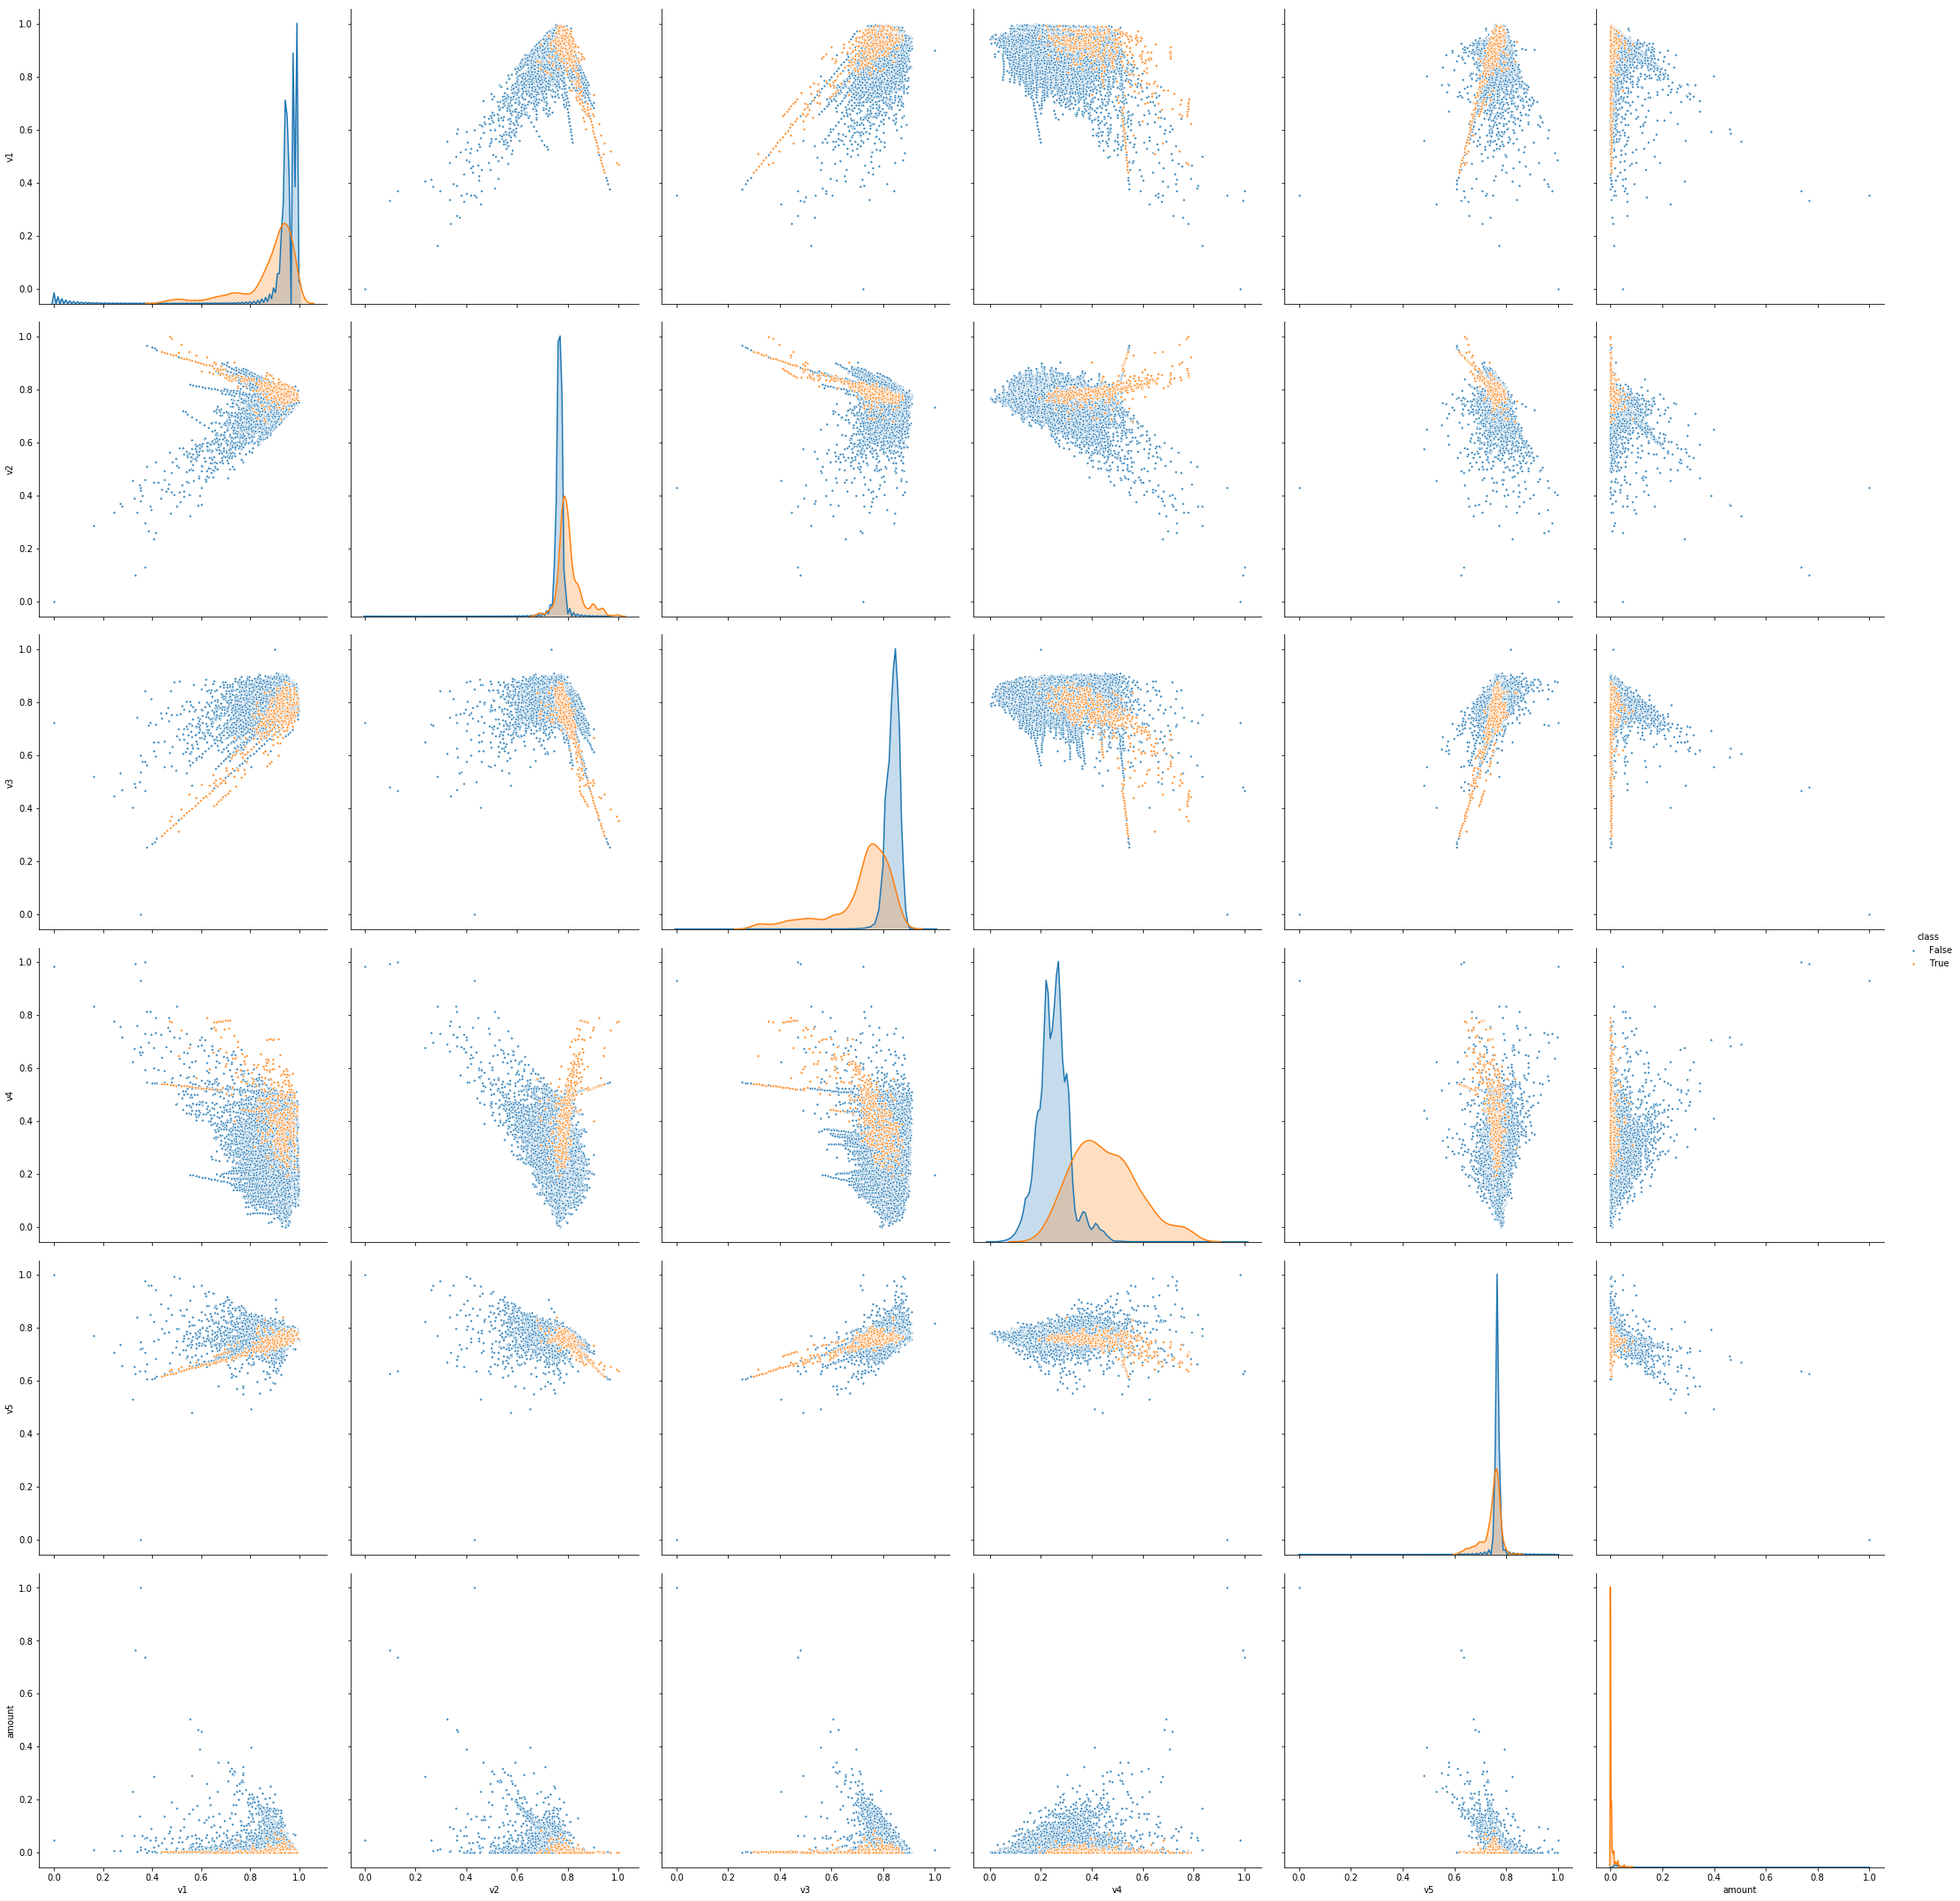

In [12]:
# Untouched data
sns.pairplot(data=scaled_data, 
             vars=['v1','v2','v3','v4','v5','amount'], 
             hue='class',
             markers='.',
             height=5,
             aspect=1)

#### Borderline SMOTE resampling technique
* Compare with dataset above (which did not use sampling) and notice the separation between classes in this dataset
* Separation between classes may lead to better generalization during training

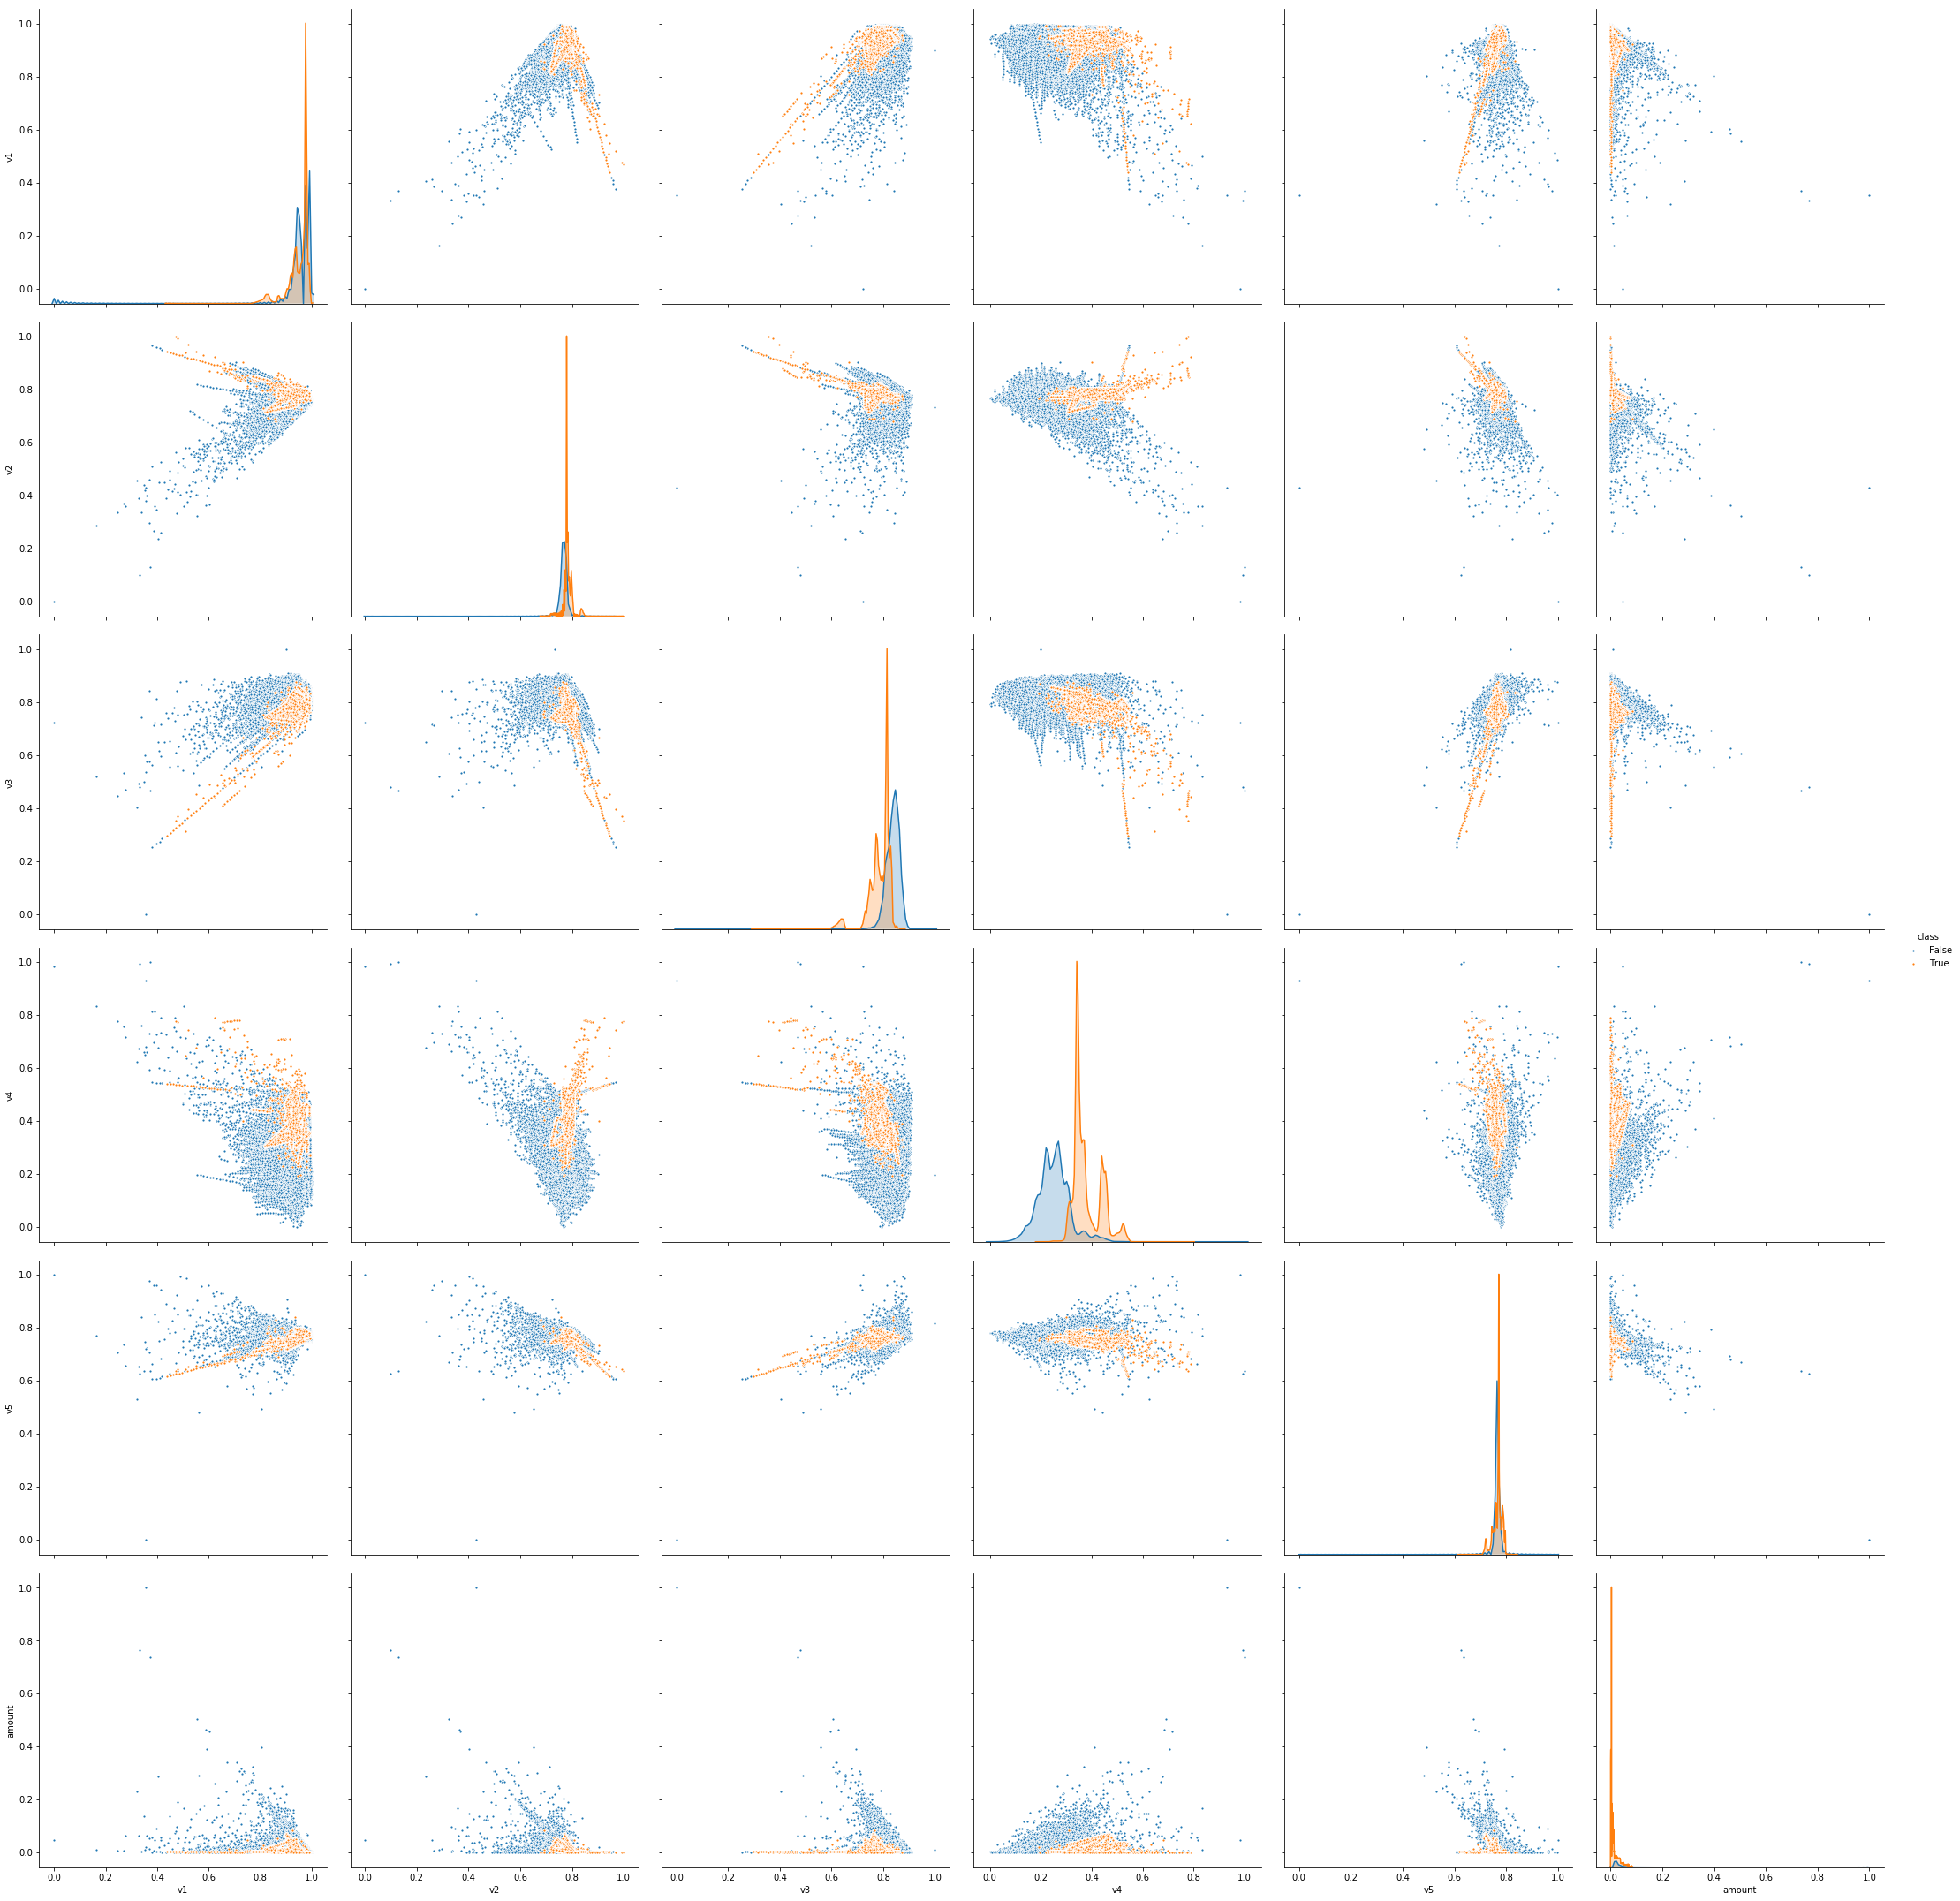

In [34]:
from imblearn.over_sampling import BorderlineSMOTE

sampler = BorderlineSMOTE()
bsmote, bsmote_labels = sampler.fit_resample(txns, txn_labels)
bsmote = pd.DataFrame(bsmote)
bsmote_labels = pd.Series(bsmote_labels)
bsmote['class'] = bsmote_labels
bsmote.columns = [*txns.columns,'class']

sns.pairplot(data=bsmote, 
             vars=['v1','v2','v3','v4','v5','amount'], 
             hue='class',
             markers='.',
             height=5,
             aspect=1)

## Modeling and Evaluation
***

### Baseline Performance
* Establish baseline model accuracy using traditional approach for **balanced** data sets
* Standard models used
  * Gaussian Naive Bayes
  * Complement Naive Bayes

In [7]:
from sklearn.naive_bayes import GaussianNB, ComplementNB

classifier = GaussianNB()
gnb, gnb_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                 df=txns, 
                                                 labels=txn_labels, 
                                                 n_folds=5, 
                                                 pos_label=True,
                                                 shuffle=True,
                                                 print_results=True,
                                                 description='Gaussian Naive Bayes')

classifier = ComplementNB()
cnb, cnb_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                 df=txns, 
                                                 labels=txn_labels, 
                                                 n_folds=5, 
                                                 pos_label=True,
                                                 shuffle=True,
                                                 print_results=True,
                                                 description='Complement Naive Bayes')


= Gaussian Naive Bayes =
Accuracy:	 0.98
AUC:		 0.90
Precision:	 0.06
Recall:		 0.83
F1:		 0.11
Average time to train:  00:00:00.266047


= Complement Naive Bayes =
Accuracy:	 1.00
AUC:		 0.88
Precision:	 0.71
Recall:		 0.77
F1:		 0.74
Average time to train:  00:00:00.109938




### Improve Baseline via Sampling Methods
* Try improving model performance with this **imbalanced** data set by using **under-sampling** and **over-sampling** methods
* Smaller datasets perform better with over-sampling
* Larger datasets perform better with under-sampling
* For this particular dataset we expect over-sampling to be more useful as there are under 500 samples in the minority class

#### Under-sampling
##### Near-Miss 2, 4 nearest neighbors

In [8]:
from imblearn.under_sampling import NearMiss

# Use NearMiss2 undersampling technique to balance data set 
# (majority class sampled until it is size N where N = size of minority class)
sampler = NearMiss(sampling_strategy='not minority', 
                   version=2, 
                   n_neighbors=4, 
                   #n_neighbors_ver3=3, 
                   n_jobs=1)

classifier = GaussianNB()
gnb_nm2, gnb_nm2_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                         df=txns, 
                                                         labels=txn_labels, 
                                                         n_folds=5, 
                                                         pos_label=True,
                                                         shuffle=True,
                                                         sampler=sampler,
                                                         print_results=True,
                                                         description='Gaussian Naive Bayes w/ NM2')

classifier = ComplementNB()
cnb_nm2, cnb_nm2_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                         df=txns, 
                                                         labels=txn_labels, 
                                                         n_folds=5, 
                                                         pos_label=True,
                                                         shuffle=True,
                                                         sampler=sampler,
                                                         print_results=True,
                                                         description='Complement Naive Bayes w/ NM2')


= Gaussian Naive Bayes w/ NM2 =
Accuracy:	 0.99
AUC:		 0.80
Precision:	 0.11
Recall:		 0.62
F1:		 0.18
Average time to train:  00:00:13.515818


= Complement Naive Bayes w/ NM2 =
Accuracy:	 1.00
AUC:		 0.84
Precision:	 0.87
Recall:		 0.68
F1:		 0.76
Average time to train:  00:00:13.418479




#### Over-sampling
##### ADASYN, 5 nearest neighbors

In [9]:
from imblearn.over_sampling import ADASYN

# Use ADASYN oversampling technique to balance data set
# (minority class sampled until it is size N where N = size of majority class)
sampler = ADASYN(sampling_strategy='not majority', 
                 n_neighbors=5,
                 n_jobs=1)

classifier = GaussianNB()
gnb_adasyn, gnb_adasyn_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                         df=txns,
                                                         labels=txn_labels, 
                                                         n_folds=5, 
                                                         pos_label=True,
                                                         shuffle=True,
                                                         sampler=sampler,
                                                         print_results=True,
                                                         description='Gaussian Naive Bayes w/ ADASYN')

classifier = ComplementNB()
cnb_adasyn, cnb_adasyn_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                         df=txns, 
                                                         labels=txn_labels, 
                                                         n_folds=5, 
                                                         pos_label=True,
                                                         shuffle=True,
                                                         sampler=sampler,
                                                         print_results=True,
                                                         description='Complement Naive Bayes w/ ADASYN')


= Gaussian Naive Bayes w/ ADASYN =
Accuracy:	 0.96
AUC:		 0.92
Precision:	 0.04
Recall:		 0.88
F1:		 0.07
Average time to train:  00:00:03.715463


= Complement Naive Bayes w/ ADASYN =
Accuracy:	 0.94
AUC:		 0.92
Precision:	 0.03
Recall:		 0.91
F1:		 0.05
Average time to train:  00:00:03.443815




##### SMOTE, 5 k_neighbors, 10 m_neighbors

In [10]:
from imblearn.over_sampling import SMOTE

# Use SMOTE oversampling technique to balance data set
# (minority class sampled until it is size N where N = size of majority class)
sampler = SMOTE(sampling_strategy='not majority', 
                k_neighbors=5,
                m_neighbors=10,
                n_jobs=1)

classifier = GaussianNB()
gnb_smote, gnb_smote_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                             df=txns, 
                                                             labels=txn_labels, 
                                                             n_folds=5, 
                                                             pos_label=True,
                                                             shuffle=True,
                                                             sampler=sampler,
                                                             print_results=True,
                                                             description='Gaussian Naive Bayes w/ SMOTE')

classifier = ComplementNB()
cnb_smote, cnb_smote_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                             df=txns, 
                                                             labels=txn_labels, 
                                                             n_folds=5, 
                                                             pos_label=True,
                                                             shuffle=True,
                                                             sampler=sampler,
                                                             print_results=True,
                                                             description='Complement Naive Bayes w/ SMOTE')


= Gaussian Naive Bayes w/ SMOTE =
Accuracy:	 0.98
AUC:		 0.92
Precision:	 0.06
Recall:		 0.86
F1:		 0.11
Average time to train:  00:00:01.674837


= Complement Naive Bayes w/ SMOTE =
Accuracy:	 1.00
AUC:		 0.88
Precision:	 0.77
Recall:		 0.77
F1:		 0.77
Average time to train:  00:00:01.385806




##### Borderline SMOTE

In [16]:
from imblearn.over_sampling import BorderlineSMOTE

sampler = BorderlineSMOTE()
classifier = GaussianNB()
gnb_bsmote, gnb_bsmote_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                             df=txns, 
                                                             labels=txn_labels, 
                                                             n_folds=5, 
                                                             pos_label=True,
                                                             shuffle=True,
                                                             sampler=sampler,
                                                             print_results=True,
                                                             description='Gaussian Naive Bayes w/ Borderline SMOTE')

classifier = ComplementNB()
cnb_bsmote, cnb_bsmote_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                             df=txns, 
                                                             labels=txn_labels, 
                                                             n_folds=5, 
                                                             pos_label=True,
                                                             shuffle=True,
                                                             sampler=sampler,
                                                             print_results=True,
                                                             description='Complement Naive Bayes w/ Borderline SMOTE')


= Gaussian Naive Bayes w/ Borderline SMOTE =
Accuracy:	 0.98
AUC:		 0.93
Precision:	 0.08
Recall:		 0.87
F1:		 0.15
Average time to train:  00:00:03.752211


= Complement Naive Bayes w/ Borderline SMOTE =
Accuracy:	 0.99
AUC:		 0.93
Precision:	 0.13
Recall:		 0.87
F1:		 0.23
Average time to train:  00:00:03.501582




#### Combination Over-/Under-sampling
##### SMOTETomek

In [13]:
from imblearn.combine import SMOTETomek

# Use SMOTETomek oversampling technique to balance data set
# (minority class sampled until it is size N where N = size of majority class, 
# then majority/minority class pairs that are closer to each other than any other pairs
# are removed from the data set -> better boundary separation)
sampler = SMOTETomek(sampling_strategy='not majority')

classifier = GaussianNB()
gnb_smotetomek,gnb_smotetomek_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                         df=txns, 
                                                         labels=txn_labels, 
                                                         n_folds=5, 
                                                         pos_label=True,
                                                         shuffle=True,
                                                         sampler=sampler,
                                                         print_results=True,
                                                         description='Gaussian Naive Bayes w/ SMOTETomek')

classifier = ComplementNB()
cnb_smotetomek,cnb_smotetomek_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                         df=txns, 
                                                         labels=txn_labels, 
                                                         n_folds=5, 
                                                         pos_label=True,
                                                         shuffle=True,
                                                         sampler=sampler,
                                                         print_results=True,
                                                         description='Complement Naive Bayes w/ SMOTETomek')


= Gaussian Naive Bayes w/ SMOTETomek =
Accuracy:	 0.98
AUC:		 0.92
Precision:	 0.06
Recall:		 0.86
F1:		 0.11
Average time to train:  00:03:29.835331


= Complement Naive Bayes w/ SMOTETomek =
Accuracy:	 1.00
AUC:		 0.88
Precision:	 0.77
Recall:		 0.77
F1:		 0.76
Average time to train:  00:03:33.214498




### Further Experimentation
* SVM
* Ensemble SVM
* SVM w/ Borderline SMOTE
* Ensemble SVM w/ Borderline SMOTE

In [14]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

# Vanilla SVC
classifier = SVC(gamma='auto')
svc,svc_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                         df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                                         labels=scaled_data['class'], 
                                                         n_folds=5, 
                                                         pos_label=True,
                                                         shuffle=True,
                                                         print_results=True,
                                                         description='SVC')
# Vanilla Bagging SVC
classifier = BaggingClassifier(base_estimator=SVC(gamma='auto'),
                               n_estimators=4,
                               n_jobs=4,
                               max_samples=.5)
esvc,esvc_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                         df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                                         labels=scaled_data['class'], 
                                                         n_folds=5, 
                                                         pos_label=True,
                                                         shuffle=True,
                                                         print_results=True,
                                                         description='SVC Bagging Ensemble')


= SVC =
Accuracy:	 1.00
AUC:		 0.78
Precision:	 0.87
Recall:		 0.56
F1:		 0.68
Average time to train:  00:00:09.651846


= SVC Bagging Ensemble =
Accuracy:	 1.00
AUC:		 0.73
Precision:	 0.85
Recall:		 0.46
F1:		 0.59
Average time to train:  00:00:04.690744




In [15]:
from imblearn.over_sampling import BorderlineSMOTE

# SVC w/ Borderline SMOTE
sampler = BorderlineSMOTE()
classifier = SVC(gamma='auto')
svc_bsmote,svc_bsmote_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                         df=txns, 
                                                         labels=txn_labels, 
                                                         n_folds=5, 
                                                         pos_label=True,
                                                         shuffle=True,
                                                         sampler=sampler,
                                                         print_results=True,
                                                         description='SVC w/ Borderline SMOTE')

# Bagging SVC w/ Borderline SMOTE
classifier = BaggingClassifier(base_estimator=SVC(gamma='auto'),
                               n_estimators=4,
                               n_jobs=4,
                               max_samples=.5)
esvc_bsmote,esvc_bsmote_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                         df=txns, 
                                                         labels=txn_labels, 
                                                         n_folds=5, 
                                                         pos_label=True,
                                                         shuffle=True,
                                                         sampler=sampler,
                                                         print_results=True,
                                                         description='SVC Bagging Ensemble w/ Borderline SMOTE')


= SVC w/ Borderline SMOTE =
Accuracy:	 0.99
AUC:		 0.93
Precision:	 0.20
Recall:		 0.86
F1:		 0.32
Average time to train:  01:21:39.397398


= SVC Bagging Ensemble w/ Borderline SMOTE =
Accuracy:	 0.99
AUC:		 0.93
Precision:	 0.16
Recall:		 0.87
F1:		 0.27
Average time to train:  00:14:27.149194




* Decision Tree
* Random Forest
* Decision Tree w/ Borderline SMOTE
* Random Forest w/ Borderline SMOTE
* XGBoost?

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Vanilla Decision Tree
classifier = DecisionTreeClassifier(criterion='gini')
dt,dt_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                              df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                              labels=scaled_data['class'], 
                                              n_folds=5, 
                                              pos_label=True,
                                              shuffle=True,
                                              print_results=True,
                                              description='Decision Tree')

# Vanilla Random Forest
classifier = RandomForestClassifier(criterion='gini',
                                    n_estimators=10,
                                    n_jobs=4)#entropy
rf,rf_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                              df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                              labels=scaled_data['class'], 
                                              n_folds=5, 
                                              pos_label=True,
                                              shuffle=True,
                                              print_results=True,
                                              description='Random Forest')


= Decision Tree =
Accuracy:	 1.00
AUC:		 0.88
Precision:	 0.76
Recall:		 0.76
F1:		 0.76
Average time to train:  00:00:14.958589


= Random Forest =
Accuracy:	 1.00
AUC:		 0.87
Precision:	 0.94
Recall:		 0.75
F1:		 0.83
Average time to train:  00:00:07.015559




In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Vanilla Decision Tree
classifier = DecisionTreeClassifier(criterion='entropy')
dt,dt_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                              df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                              labels=scaled_data['class'], 
                                              n_folds=5, 
                                              pos_label=True,
                                              shuffle=True,
                                              print_results=True,
                                              description='Decision Tree')

# Vanilla Random Forest
classifier = RandomForestClassifier(criterion='entropy',
                                    n_estimators=10,
                                    n_jobs=4)#entropy
rf,rf_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                              df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                              labels=scaled_data['class'], 
                                              n_folds=5, 
                                              pos_label=True,
                                              shuffle=True,
                                              print_results=True,
                                              description='Random Forest')


= Decision Tree =
Accuracy:	 1.00
AUC:		 0.88
Precision:	 0.77
Recall:		 0.75
F1:		 0.76
Average time to train:  00:00:10.047018


= Random Forest =
Accuracy:	 1.00
AUC:		 0.88
Precision:	 0.96
Recall:		 0.76
F1:		 0.84
Average time to train:  00:00:05.057243




In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE

# Decision Tree w/ Borderline SMOTE
sampler = BorderlineSMOTE()
classifier = DecisionTreeClassifier(criterion='gini')
dt,dt_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                              df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                              labels=scaled_data['class'], 
                                              n_folds=5, 
                                              pos_label=True,
                                              shuffle=True,
                                              sampler=sampler,
                                              print_results=True,
                                              description='Decision Tree w/ Borderline SMOTE')
 
# Random Forest w/ Borderline SMOTE
classifier = RandomForestClassifier(criterion='gini',
                                    n_estimators=10,
                                    n_jobs=4)#entropy
rf,rf_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                              df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                              labels=scaled_data['class'], 
                                              n_folds=5, 
                                              pos_label=True,
                                              shuffle=True,
                                              sampler=sampler,
                                              print_results=True,
                                              description='Random Forest w/ Borderline SMOTE')


= Decision Tree w/ Borderline SMOTE =
Accuracy:	 1.00
AUC:		 0.87
Precision:	 0.73
Recall:		 0.74
F1:		 0.73
Average time to train:  00:00:50.506129


= Random Forest w/ Borderline SMOTE =
Accuracy:	 1.00
AUC:		 0.89
Precision:	 0.92
Recall:		 0.77
F1:		 0.84
Average time to train:  00:00:18.418052




In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE

# Decision Tree w/ Borderline SMOTE
sampler = BorderlineSMOTE()
classifier = DecisionTreeClassifier(criterion='entropy')
dt,dt_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                              df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                              labels=scaled_data['class'], 
                                              n_folds=5, 
                                              pos_label=True,
                                              shuffle=True,
                                              sampler=sampler,
                                              print_results=True,
                                              description='Decision Tree w/ Borderline SMOTE')
 
# Random Forest w/ Borderline SMOTE
classifier = RandomForestClassifier(criterion='entropy',
                                    n_estimators=10,
                                    n_jobs=4)#entropy
rf,rf_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                              df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                              labels=scaled_data['class'], 
                                              n_folds=5, 
                                              pos_label=True,
                                              shuffle=True,
                                              sampler=sampler,
                                              print_results=True,
                                              description='Random Forest w/ Borderline SMOTE')


= Decision Tree w/ Borderline SMOTE =
Accuracy:	 1.00
AUC:		 0.88
Precision:	 0.72
Recall:		 0.76
F1:		 0.73
Average time to train:  00:00:31.235824


= Random Forest w/ Borderline SMOTE =
Accuracy:	 1.00
AUC:		 0.89
Precision:	 0.94
Recall:		 0.77
F1:		 0.85
Average time to train:  00:00:14.731691




In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN

# Decision Tree w/ ADASYN
sampler = ADASYN()
classifier = DecisionTreeClassifier(criterion='entropy')
dt_adasyn,dt_adasyn_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                              df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                              labels=scaled_data['class'], 
                                              n_folds=5, 
                                              pos_label=True,
                                              shuffle=True,
                                              sampler=sampler,
                                              print_results=True,
                                              description='Decision Tree w/ ADASYN')
 
# Random Forest w/ ADASYN
classifier = RandomForestClassifier(criterion='entropy',
                                    n_estimators=10,
                                    n_jobs=4)#entropy
rf_adasyn,rf_adasyn_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                              df=scaled_data[[col for col in scaled_data.columns if col != 'class']], 
                                              labels=scaled_data['class'], 
                                              n_folds=5, 
                                              pos_label=True,
                                              shuffle=True,
                                              sampler=sampler,
                                              print_results=True,
                                              description='Random Forest w/ ADASYN')


= Decision Tree w/ ADASYN =
Accuracy:	 1.00
AUC:		 0.89
Precision:	 0.44
Recall:		 0.78
F1:		 0.56
Average time to train:  00:00:36.033254


= Random Forest w/ ADASYN =
Accuracy:	 1.00
AUC:		 0.91
Precision:	 0.87
Recall:		 0.81
F1:		 0.84
Average time to train:  00:00:16.644670




### Finalize model
* Choose best sampling/model pair
* Parameter adjustment
* **Result: **
  
    **Complement NB (alpha=1.0) w/ Borderline SMOTE**

    **Precision: 0.13**
  
    **Recall: 0.88**

In [35]:
sampler = BorderlineSMOTE()
classifiers = {}
for i in range(0,10):
    alpha = (i+1)/10
    classifier = ComplementNB(alpha=alpha)
    cnb_bsmote, cnb_bsmote_metrics = ml.train_and_score_classifier(classifier=classifier, 
                                                             df=txns, 
                                                             labels=txn_labels, 
                                                             n_folds=5, 
                                                             pos_label=True,
                                                             shuffle=True,
                                                             sampler=sampler,
                                                             print_results=True,
                                                             description='Complement Naive Bayes w/ Borderline SMOTE, alpha={0}'.format(alpha))
    classifiers[str(alpha)] = cnb_bsmote

= Complement Naive Bayes w/ Borderline SMOTE, alpha=0.1 =
Accuracy:	 0.99
AUC:		 0.93
Precision:	 0.10
Recall:		 0.87
F1:		 0.18
Average time to train:  00:00:03.444020


= Complement Naive Bayes w/ Borderline SMOTE, alpha=0.2 =
Accuracy:	 0.99
AUC:		 0.93
Precision:	 0.10
Recall:		 0.88
F1:		 0.17
Average time to train:  00:00:03.408641


= Complement Naive Bayes w/ Borderline SMOTE, alpha=0.3 =
Accuracy:	 0.99
AUC:		 0.93
Precision:	 0.14
Recall:		 0.87
F1:		 0.23
Average time to train:  00:00:03.461409


= Complement Naive Bayes w/ Borderline SMOTE, alpha=0.4 =
Accuracy:	 0.99
AUC:		 0.93
Precision:	 0.14
Recall:		 0.87
F1:		 0.23
Average time to train:  00:00:03.662893


= Complement Naive Bayes w/ Borderline SMOTE, alpha=0.5 =
Accuracy:	 0.99
AUC:		 0.93
Precision:	 0.11
Recall:		 0.88
F1:		 0.19
Average time to train:  00:00:03.458913


= Complement Naive Bayes w/ Borderline SMOTE, alpha=0.6 =
Accuracy:	 0.99
AUC:		 0.93
Precision:	 0.10
Recall:		 0.88
F1:		 0.19
Average time to 

#### Precision-Recall Curve

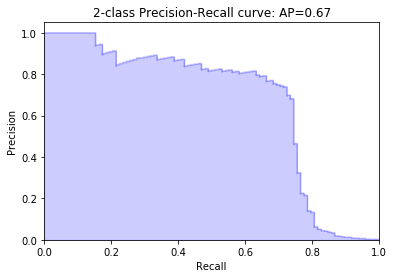

In [251]:
from sklearn.model_selection import train_test_split

# Choose sampling method and classifier
sampler = BorderlineSMOTE()
classifier = ComplementNB(alpha=1.0)

# Create an 80/20 train/test split, then resample the split data
train_x, test_x, train_y, test_y = train_test_split(txns,txn_labels,test_size=.2,shuffle=True,stratify=txn_labels)
train_x, train_y = sampler.fit_resample(train_x, train_y)
train_x = pd.DataFrame(train_x)
train_y = pd.Series(train_y)

test_x = pd.DataFrame(test_x) 
test_y = pd.Series(test_y) 

# Train classifier
classifier.fit(train_x, train_y)

# Generate precision-recall curve
show_precision_recall_curve(classifier, test_x, test_y)


## Deployment
***
### Persist model

In [61]:
from sklearn.externals import joblib

best_alpha = 1.0
model = classifiers[str(best_alpha)]
model_file_name = 'saved_model.txt'

# Save classifier to text file
joblib.dump(model,model_file_name)

# Load classifier byte sequence from text file to classifier object
loaded_model = joblib.load(model_file_name)

# Validate signature of loaded model
print(model)
print(loaded_model)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)


## Future Enhancements
***
* Feature scaling: use distribution plots to see if some features should use a non-linear scaling function